Paired TAM (transcient abnormal myleoproliferation) vs AML (acute myeloid leukemia) analysis of patients with the co-occuring condition of Down Syndrome using DESeq2 on IJC counts obtained from rMATS analysis.

Using a matrix constructed from Kids First Workflow V4 done on single runs, a series of scripts were created and are stored in this repository.  For each of the splicing types, all the runs considered for analysis are pooled and normalized to have a non-redundant set of splicing events.  A matrix is then constructed for each of the samples to be analyzed.  

Each splicing type has a bed file for visualizaiton in UCSC Genome browser of all the events, as well as created a matrix of the single runs normalized to the non-redundant union of files.  Both the source and the normalized bed file are available to ensure interprebility of results. 

Using associative arrays in an awk script, it was a rapid way to transform the individual counts from each of the individual runs into a matrix that facilitated analysis.

Using annotations obtained from the rMATS run that provided the coordinates of each of the splicing events as well as the gene that the junctions came from and the count of the reads that overlapped the junctions.   
 
Limma in this notebook is used to perform analysis of these junction counts provided by the rMATS routine.  Using these counts as junction expression.

Between the splicing event differences and the expression differences, between paired samples, biological functional differences may be obtained.


In [1]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager", repos = "https://cloud.r-project.org")


In [2]:
BiocManager::install("dplyr")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.22), R 4.3.1 (2023-06-16)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'dplyr'”
Old packages: 'edgeR', 'evaluate', 'GenomeInfoDb', 'ggplot2', 'lifecycle',
  'RcppArmadillo', 'scales', 'SparseArray', 'xfun'



In [3]:
library(Glimma)
library(dplyr)
library(edgeR)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: limma



In [4]:
setwd("../paired.TAM.AMLv2/")


In [5]:
getwd()


[1] "/Users/annedeslattesmays/Desktop/projects/post-rmats-single-run/paired.TAM.AMLv2"

In [6]:
cts <- as.matrix(read.csv("MXE.IJC.w.coordinates.matrix.csv",sep=",",row.names="ID"))

In [7]:
cts[1:3,13:dim(cts)[2]]

,PAUVKY.03A,PAUVKY.40A,PAWHSD.03A,PAWHSD.40A,PAWSNZ.03A,PAWSNZ.40A,X_1_PAUTLA.03A,X_1_PAUTLA.40A,X_1_PAVUDU.03A,X_1_PAVUDU.40A
1,22,19,0,0,9,16,26,11,26,17
2,0,0,0,0,0,0,28,30,31,46
3,52,76,35,22,80,66,124,51,136,65


In [8]:
featureData <- cts[,1:12]
featureData[1:3,]

,GeneID,geneSymbol,chr,strand,X1stStart_0base,X1stexonEnd,X2ndExonStart_0base,X2ndExonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
1,ENSG00000117620.15,SLC35A3,chr1,+,100007033,100007156,100009287,100009323,99993536,99993741,100011364,100011533
2,ENSG00000117620.15,SLC35A3,chr1,+,100007033,100007156,100009287,100009323,99999260,99999415,100011364,100011533
3,ENSG00000283761.1,ENSG00000283761,chr1,+,100015301,100015420,100043072,100043229,100011364,100011533,100049908,100050004


In [9]:
featureData <- featureData[,c(1,2)]

In [10]:
head(featureData,2)

,GeneID,geneSymbol
1,ENSG00000117620.15,SLC35A3
2,ENSG00000117620.15,SLC35A3


In [11]:
cts <- data.matrix(cts[,13:dim(cts)[2]])

In [12]:
dim(cts)
head(cts,2)

[1] 19548    10

,PAUVKY.03A,PAUVKY.40A,PAWHSD.03A,PAWHSD.40A,PAWSNZ.03A,PAWSNZ.40A,X_1_PAUTLA.03A,X_1_PAUTLA.40A,X_1_PAVUDU.03A,X_1_PAVUDU.40A
1,22,19,0,0,9,16,26,11,26,17
2,0,0,0,0,0,0,28,30,31,46


In [13]:
colnames(cts) <- c("PAUVKY.03A","PAUVKY.40A","PAWHSD.03A","PAWHSD.40A","PAWSNZ.03A","PAWSNZ.40A","PAUTLA.03A","PAUTLA.40A","PAVUDU.03A","PAVUDU.40A")

The PAWHSD samples are not TAM and AML but in fact TAM and TAM - the resulting heatmap when included showed they clustered together.  We will eliminate them from subsequent analyses.

In [14]:
cts <- cts[,-c(3:4)]
dim(cts)

[1] 19548     8

In [15]:
head(cts,2)

,PAUVKY.03A,PAUVKY.40A,PAWSNZ.03A,PAWSNZ.40A,PAUTLA.03A,PAUTLA.40A,PAVUDU.03A,PAVUDU.40A
1,22,19,9,16,26,11,26,17
2,0,0,0,0,28,30,31,46


In [16]:
# Condition 1: Rows with count > 1000 in columns 1, 3, 5, 7
TAM_rows_condition <- rowSums(cts[, c(1, 3, 5, 7)] > 1000) > 0
TAM_matrix<- cts[TAM_rows_condition, c(1, 3, 5, 7)]

# Condition 2: Rows with count > 1000 in columns 2, 4, 6, 8
AML_rows_condition <- rowSums(cts[, c(2, 4, 6, 8)] > 1000) > 0
AML_matrix <- cts[AML_rows_condition, c(2, 4, 6, 8)]

# Combine the sub-matrices by keeping rows that satisfy either condition 1 or condition 2
final_matrix <- cts[AML_rows_condition | TAM_rows_condition, ]

# View the dimensions of the resulting matrices
dim(TAM_matrix)
dim(AML_matrix)
dim(final_matrix)


[1] 96  4

[1] 72  4

[1] 140   8

In [17]:
head(TAM_matrix)
head(AML_matrix)
head(final_matrix)

,PAUVKY.03A,PAWSNZ.03A,PAUTLA.03A,PAVUDU.03A
618,1458,2601,1926,2003
789,1234,1350,2433,1877
945,3505,5112,0,4843
1056,1077,1292,1879,1266
1058,935,986,1552,1062
1192,1841,1758,2420,1538


,PAUVKY.40A,PAWSNZ.40A,PAUTLA.40A,PAVUDU.40A
619,1090,0,0,0
945,3544,0,0,6080
1096,0,3553,0,0
1264,1065,565,893,2049
1718,0,0,1492,0
1719,606,634,1101,0


,PAUVKY.03A,PAUVKY.40A,PAWSNZ.03A,PAWSNZ.40A,PAUTLA.03A,PAUTLA.40A,PAVUDU.03A,PAVUDU.40A
618,1458,0,2601,0,1926,0,2003,0
619,0,1090,0,0,0,0,0,0
789,1234,871,1350,428,2433,618,1877,1377
945,3505,3544,5112,0,0,0,4843,6080
1056,1077,862,1292,612,1879,857,1266,0
1058,935,752,986,500,1552,707,1062,1173


In [18]:
cts <- final_matrix

featureData <- featureData[rownames(cts),]

In [19]:
coldata <- read.csv("design_matrix.csv",row.names=1)

In [20]:
coldata


,patient,condition
,<chr>,<chr>
PAUVKY-03A,PAUVKY,TAM
PAUVKY-40A,PAUVKY,AML
PAWSNZ-03A,PAWSNZ,TAM
PAWSNZ-40A,PAWSNZ,AML
PAUTLA-03A,PAUTLA,TAM
PAUTLA-40A,PAUTLA,AML
PAVUDU-03A,PAVUDU,TAM
PAVUDU-40A,PAVUDU,AML


In [21]:
coldata <- coldata[,c("patient","condition")]
coldata$condition <- factor(coldata$condition)
coldata$patient <- factor(coldata$patient)

In [22]:
rownames(coldata)

[1] "PAUVKY-03A" "PAUVKY-40A" "PAWSNZ-03A" "PAWSNZ-40A" "PAUTLA-03A"
[6] "PAUTLA-40A" "PAVUDU-03A" "PAVUDU-40A"

In [23]:
rownames(coldata) <-sub("-",".",rownames(coldata))

In [24]:
colnames(cts)

[1] "PAUVKY.03A" "PAUVKY.40A" "PAWSNZ.03A" "PAWSNZ.40A" "PAUTLA.03A"
[6] "PAUTLA.40A" "PAVUDU.03A" "PAVUDU.40A"

In [25]:
all(rownames(coldata) %in% colnames(cts))

[1] TRUE

In [26]:
colnames(cts)

[1] "PAUVKY.03A" "PAUVKY.40A" "PAWSNZ.03A" "PAWSNZ.40A" "PAUTLA.03A"
[6] "PAUTLA.40A" "PAVUDU.03A" "PAVUDU.40A"

In [27]:
dim(cts)
head(cts,4)
mode(cts) <- "integer"
is.integer(cts)

[1] 140   8

,PAUVKY.03A,PAUVKY.40A,PAWSNZ.03A,PAWSNZ.40A,PAUTLA.03A,PAUTLA.40A,PAVUDU.03A,PAVUDU.40A
618,1458,0,2601,0,1926,0,2003,0
619,0,1090,0,0,0,0,0,0
789,1234,871,1350,428,2433,618,1877,1377
945,3505,3544,5112,0,0,0,4843,6080


[1] TRUE

In [28]:
# lets look at limma/voom
BiocManager::install("limma")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.22), R 4.3.1 (2023-06-16)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'limma'”
Old packages: 'edgeR', 'evaluate', 'GenomeInfoDb', 'ggplot2', 'lifecycle',
  'RcppArmadillo', 'scales', 'SparseArray', 'xfun'



In [29]:
BiocManager::install("statmod")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.22), R 4.3.1 (2023-06-16)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'statmod'”
Old packages: 'edgeR', 'evaluate', 'GenomeInfoDb', 'ggplot2', 'lifecycle',
  'RcppArmadillo', 'scales', 'SparseArray', 'xfun'



In [30]:
library(limma)
library(edgeR)
library(statmod)

In [31]:
# making a counts matrix
dge <- DGEList(counts=cts)

In [32]:
colnames(dge)

[1] "PAUVKY.03A" "PAUVKY.40A" "PAWSNZ.03A" "PAWSNZ.40A" "PAUTLA.03A"
[6] "PAUTLA.40A" "PAVUDU.03A" "PAVUDU.40A"

In [33]:
head(dge,2)

An object of class "DGEList"
$counts
    PAUVKY.03A PAUVKY.40A PAWSNZ.03A PAWSNZ.40A PAUTLA.03A PAUTLA.40A
618       1458          0       2601          0       1926          0
619          0       1090          0          0          0          0
    PAVUDU.03A PAVUDU.40A
618       2003          0
619          0          0

$samples
           group lib.size norm.factors
PAUVKY.03A     1   145779            1
PAUVKY.40A     1   107967            1
PAWSNZ.03A     1   244262            1
PAWSNZ.40A     1    66552            1
PAUTLA.03A     1   290745            1
PAUTLA.40A     1   133703            1
PAVUDU.03A     1   225326            1
PAVUDU.40A     1   185297            1

In [34]:
design <- model.matrix(~ 0 + factor(c(1,2,1,2,1,2,1,2)))
colnames(design) <- c("TAM","AML")

In [35]:
design

,TAM,AML
1,1,0
2,0,1
3,1,0
4,0,1
5,1,0
6,0,1
7,1,0
8,0,1


In [36]:
# normalize and filter
keep          <-filterByExpr(dge, design)

In [37]:
is.logical(keep)
sum(keep==TRUE)

[1] TRUE

[1] 72

In [38]:
dge          <- dge         [keep,,keep.lib.size=FALSE]

In [39]:
# apply scale normalization
dge          <- calcNormFactors(dge)

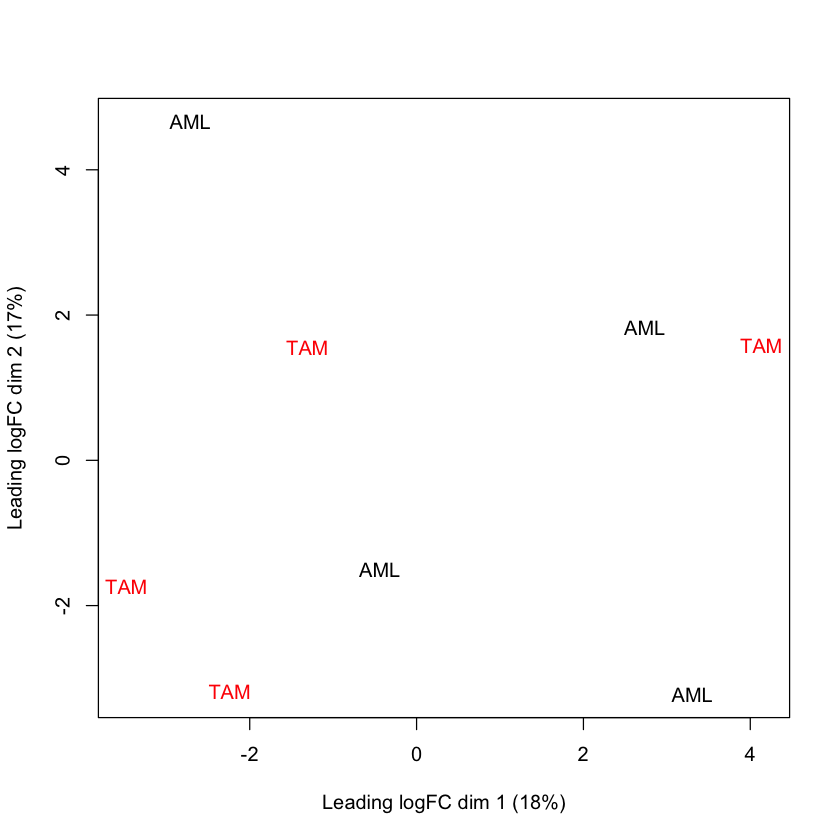

In [40]:
# MDS Plot - can we separate the samples well?
logCPM <- cpm(dge, log=TRUE, prior.count=3)
plotMDS(logCPM,labels=coldata$condition,top=10, col=c(rep(c("red","black"),3)))

In [41]:
head(logCPM)

,PAUVKY.03A,PAUVKY.40A,PAWSNZ.03A,PAWSNZ.40A,PAUTLA.03A,PAUTLA.40A,PAVUDU.03A,PAVUDU.40A
618,13.58831,4.624441,14.10939,4.624441,13.467858,4.624441,13.72606,4.624441
789,13.34818,13.061112,13.16515,12.961404,13.804332,12.912247,13.63251,13.148042
945,14.85204,15.082602,15.08322,4.624441,4.624441,4.624441,14.99826,15.287550
1056,13.15236,13.046171,13.10197,13.475983,13.432294,13.382648,13.06571,4.624441
1058,12.94897,12.849831,12.71328,13.185078,13.157136,13.105770,12.81301,12.917399
1192,13.92420,12.933405,13.54522,13.597720,13.796616,13.319127,13.34575,12.929607


In [42]:
head(dge,2)

An object of class "DGEList"
$counts
    PAUVKY.03A PAUVKY.40A PAWSNZ.03A PAWSNZ.40A PAUTLA.03A PAUTLA.40A
618       1458          0       2601          0       1926          0
789       1234        871       1350        428       2433        618
    PAVUDU.03A PAVUDU.40A
618       2003          0
789       1877       1377

$samples
           group lib.size norm.factors
PAUVKY.03A     1   106103    1.1178696
PAUVKY.40A     1    98586    1.0366932
PAWSNZ.03A     1   172704    0.8532453
PAWSNZ.40A     1    54513    0.9874068
PAUTLA.03A     1   177281    0.9609258
PAUTLA.40A     1    85859    0.9366974
PAVUDU.03A     1   149105    0.9931192
PAVUDU.40A     1   132752    1.1457715

In [43]:
fit <- lmFit(logCPM, design)
fit <- eBayes(fit, trend=TRUE)
de_results <- topTable(fit, coef=ncol(design), n=Inf) 
lookup <- rownames(de_results)
length(featureData[lookup,2])
head(featureData[lookup,2])

[1] 72

10325             17917             17921             17918 
           "PTMA"          "PABPC1"          "PABPC1"          "PABPC1" 
            17919              4298 
         "PABPC1" "ENSG00000257379"

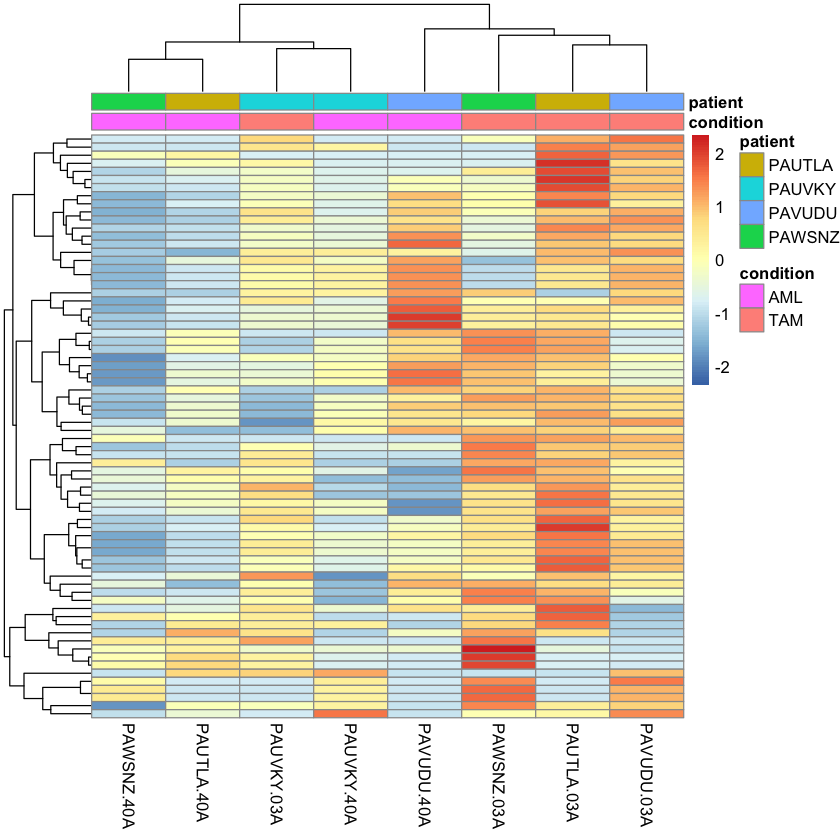

In [44]:
library("pheatmap")
df <- as.data.frame(coldata[,c("condition","patient")])
dge_expression <- dge[lookup,]
out <- pheatmap(dge_expression, cluster_rows5=TRUE, show_rownames=FALSE,
         cluster_cols=TRUE, annotation_col=df, scale="row",clustering_distance_cols = "minkowski", clustering_distance_rows = "minkowski" )

In [45]:
# Assuming you have the 'de_results' object from topTable
fold_change_threshold <- 9
adjusted_pvalue_threshold <- 0.05

# Select genes that meet both fold change and adjusted p-value criteria
significant_genes <- de_results[
  abs(de_results$logFC) > fold_change_threshold &
  de_results$adj.P.Val < adjusted_pvalue_threshold,
]
dim(significant_genes)

[1] 64  6

In [46]:
lookup <- rownames(significant_genes)
significant_expression <- dge[lookup,]

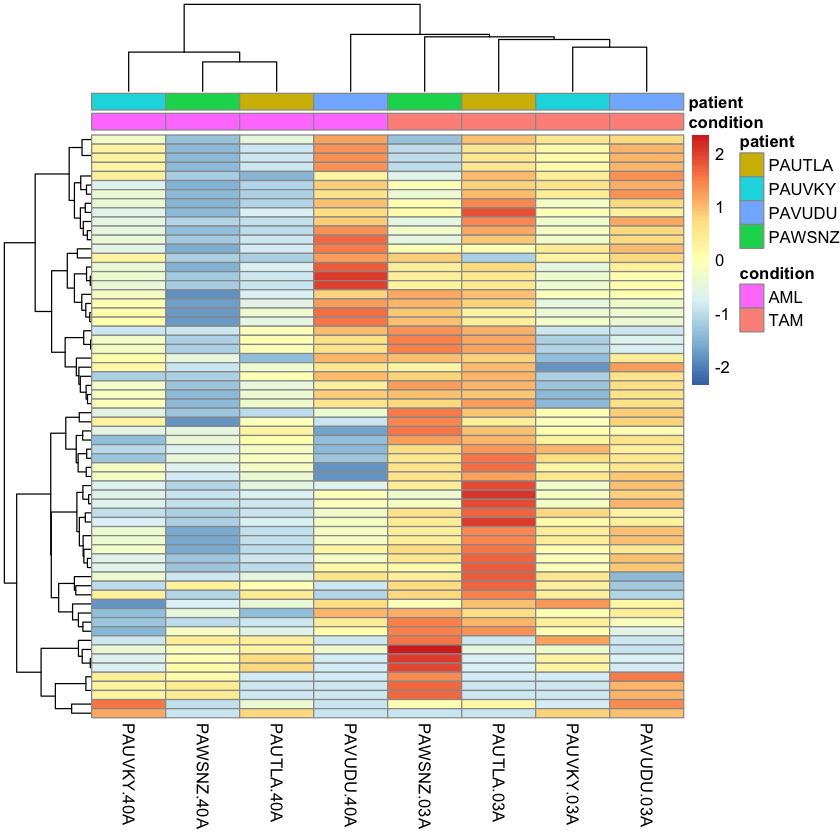

In [47]:
significant_out <- pheatmap(significant_expression, 
                            cluster_rows5=TRUE, 
                            show_rownames=FALSE,
                            cluster_cols=TRUE, 
                            annotation_col=df, 
                            scale="row",
                            clustering_method = "ward.D2",
                            clustering_distance_cols = "minkowski", 
                            clustering_distance_rows = "minkowski" )

In [48]:
featureData[head(rownames(significant_expression),5),2]

10325    17917    17921    17918    17919 
  "PTMA" "PABPC1" "PABPC1" "PABPC1" "PABPC1"

In [49]:
top_gene_list <- as.matrix(featureData[rownames(significant_expression),2])
length(top_gene_list)


[1] 64

In [50]:
top_significant_genes <- dge[rownames(significant_genes),]

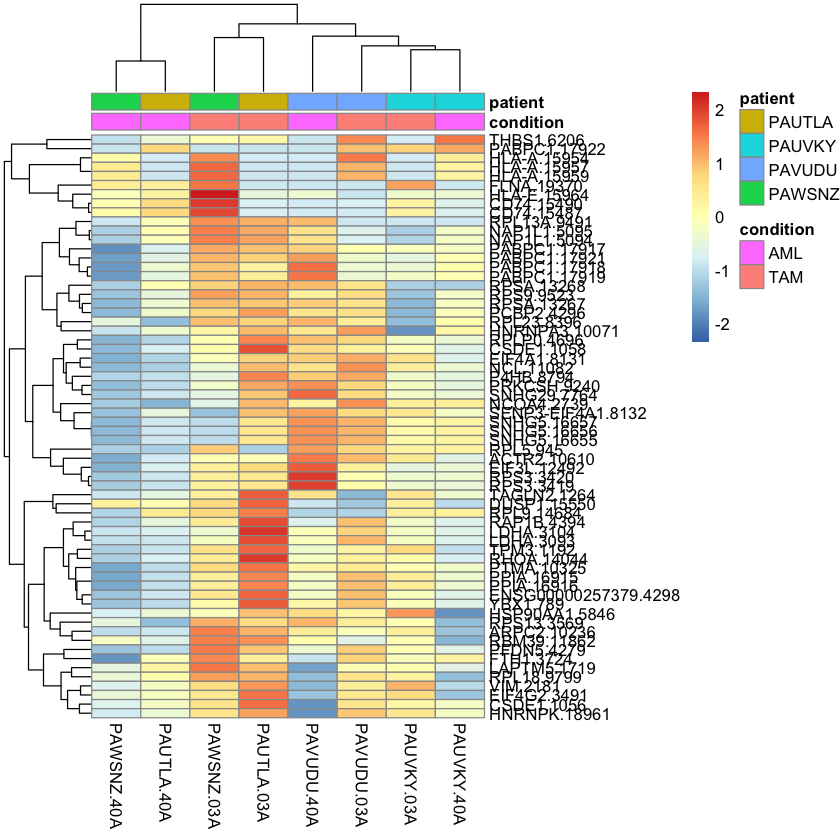

In [51]:
start=1
stop=length(top_gene_list)
date="2024Feb26_dge"
piece <-top_significant_genes[significant_out$tree_row$order[start:stop],]
fd <- data.frame(featureData[rownames(piece),])
genejunction <- paste(featureData[rownames(piece),2],rownames(piece),sep=".")
rownames(fd) <- genejunction
rownames(piece) <- genejunction
outpiece<-pheatmap(piece, cluster_rows5=TRUE, show_rownames=TRUE,
         cluster_cols=TRUE, annotation_col=df, scale="row",clustering_distance_cols = "minkowski", clustering_distance_rows = "minkowski" )
piece_filename <- paste(paste(paste(paste(date,"MXE_string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")

# Order by TAM elements, followed by AML elements
piece_exp <- piece[,c(1,3,5,7,2,4,6,8)]
colnames(piece_exp) <- colnames(piece[,c(1,3,5,7,2,4,6,8)])
rownames(piece_exp) <- rownames(piece)
string_filename <- paste(paste(paste(paste(date,"MXE_string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
piece_exp_filename <- paste(paste(paste(paste(date,"MXE_expression_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
write.csv(piece_exp$counts,piece_exp_filename,quote=FALSE)
write.csv(rownames(piece),piece_filename,quote=FALSE,row.names=FALSE)
write.csv(fd[,2],string_filename,quote=FALSE,row.names=FALSE)

In [52]:
#If you want something like gene-to-cluster assignment, you can 'cut' your row dendrogram into a pre-selected number of groups as follows:
# -- inspecating above the rows seem to fall into 4 groups
clusters<- as.matrix(row_clusters<- sort(cutree(significant_out$tree_row, k=4)),nrows=dim(top_genes_expression)[1],ncols=1)
genes_in_clusters = featureData[rownames(clusters),2]
genes_in_clusters.df <- data.frame(featureData[rownames(clusters),2], clusters)
colnames(genes_in_clusters.df) <- c("geneSymbol","cluster")
dim(genes_in_clusters.df)
cluster_1_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 1,]
cluster_2_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 2,]
cluster_3_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 3,]
cluster_4_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 4,]

cluster_1_filename <- paste(paste(date, "_dge_cluster_1", sep="_"),"csv",sep=".")
cluster_2_filename <- paste(paste(date, "_dge_cluster_2", sep="_"),"csv",sep=".")
cluster_3_filename <- paste(paste(date, "_dge_cluster_3", sep="_"),"csv",sep=".")
cluster_4_filename <- paste(paste(date, "_dge_cluster_4", sep="_"),"csv",sep=".")

write.csv(cluster_1_genes$geneSymbol,cluster_1_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_2_genes$geneSymbol,cluster_2_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_3_genes$geneSymbol,cluster_3_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_4_genes$geneSymbol,cluster_4_filename,quote=FALSE,row.names=FALSE)


[1] 64  2

In [53]:
dim(cluster_1_genes)
dim(cluster_2_genes)
dim(cluster_3_genes)
dim(cluster_4_genes)


[1] 25  2

[1] 18  2

[1] 12  2

[1] 9 2

Weights and voom were explored for improvement - but improvement over the above clustering was not observed.

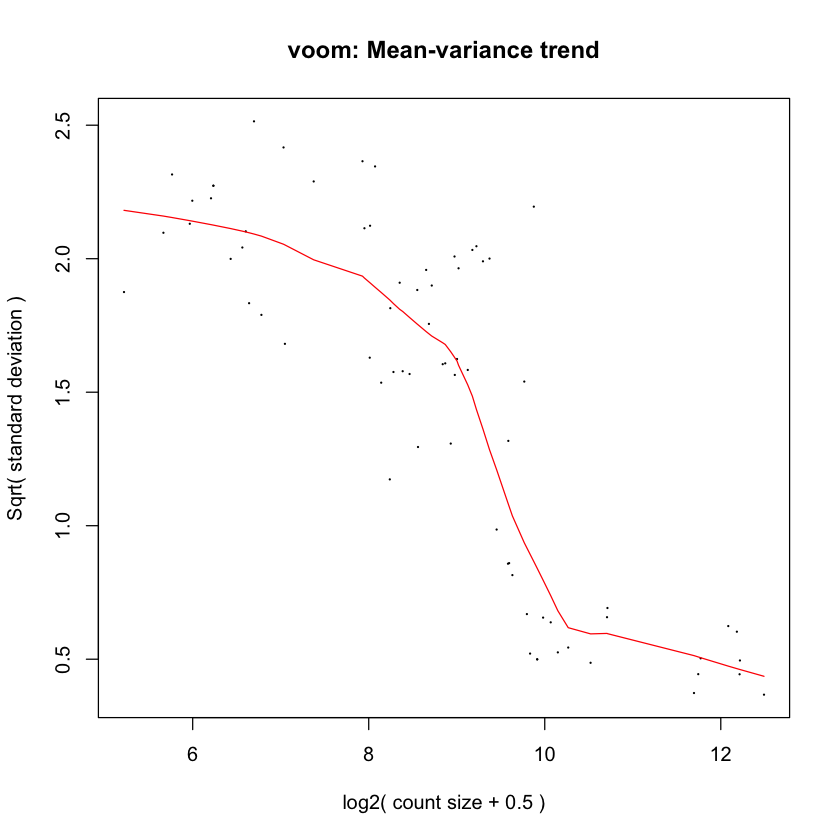

In [54]:
# weighting 
v <- voom(dge, plot=TRUE, normalize="quantile")

The striated pattern is likely due to the junctions shared expression of the gene - skewing the counting a bit and creating a non-random pattern

In [55]:
vfit <- lmFit(v, design)
vfit <- eBayes(vfit, trend=TRUE)
de_results <- topTable(vfit, coef=ncol(design), n=Inf) 
lookup <- rownames(de_results)
length(featureData[lookup,2])
head(featureData[lookup,2])


[1] 72

17921     3420    17918    17917    10325    17919 
"PABPC1"   "RPS3" "PABPC1" "PABPC1"   "PTMA" "PABPC1"

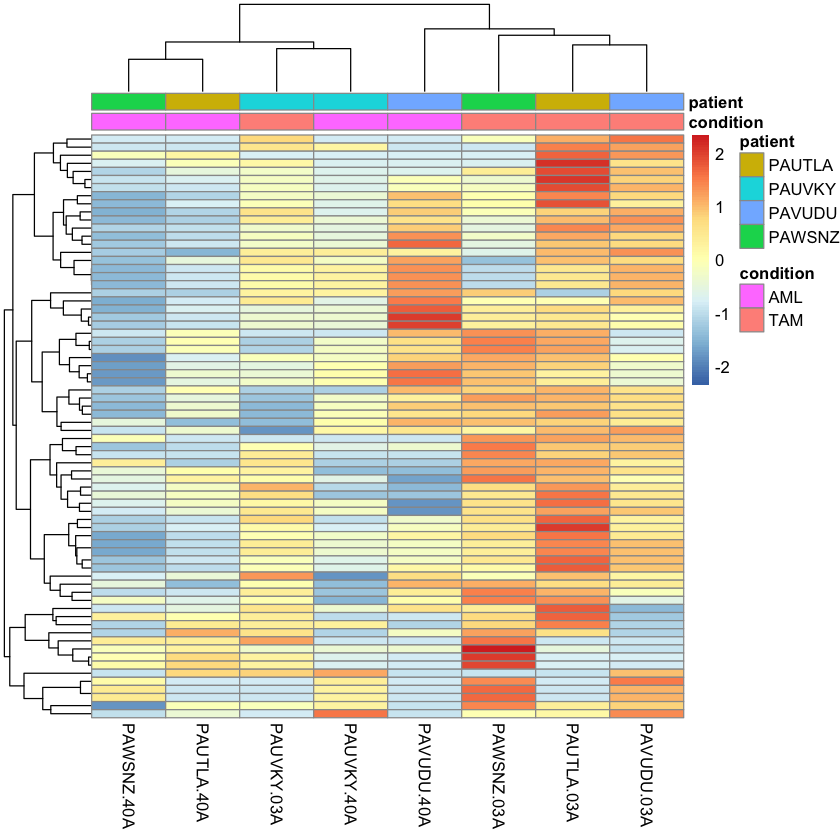

In [56]:
library("pheatmap")
df <- as.data.frame(coldata[,c("condition","patient")])
dge_expression <- dge[lookup,]
out <- pheatmap(dge_expression, cluster_rows5=TRUE, show_rownames=FALSE,
         cluster_cols=TRUE, annotation_col=df, scale="row",clustering_distance_cols = "minkowski", clustering_distance_rows = "minkowski" )

This results in worse clustering than linear fitting and Bayes analysis without weights so we will not continue.


In [57]:
# Assuming you have the 'de_results' object from topTable
fold_change_threshold <- 10
adjusted_pvalue_threshold <- 0.05

# Select genes that meet both fold change and adjusted p-value criteria
significant_genes <- de_results[
  abs(de_results$logFC) > fold_change_threshold &
  de_results$adj.P.Val < adjusted_pvalue_threshold,
]
dim(significant_genes)

[1] 55  6

In [58]:
lookup <- rownames(significant_genes)
significant_expression <- dge[lookup,]


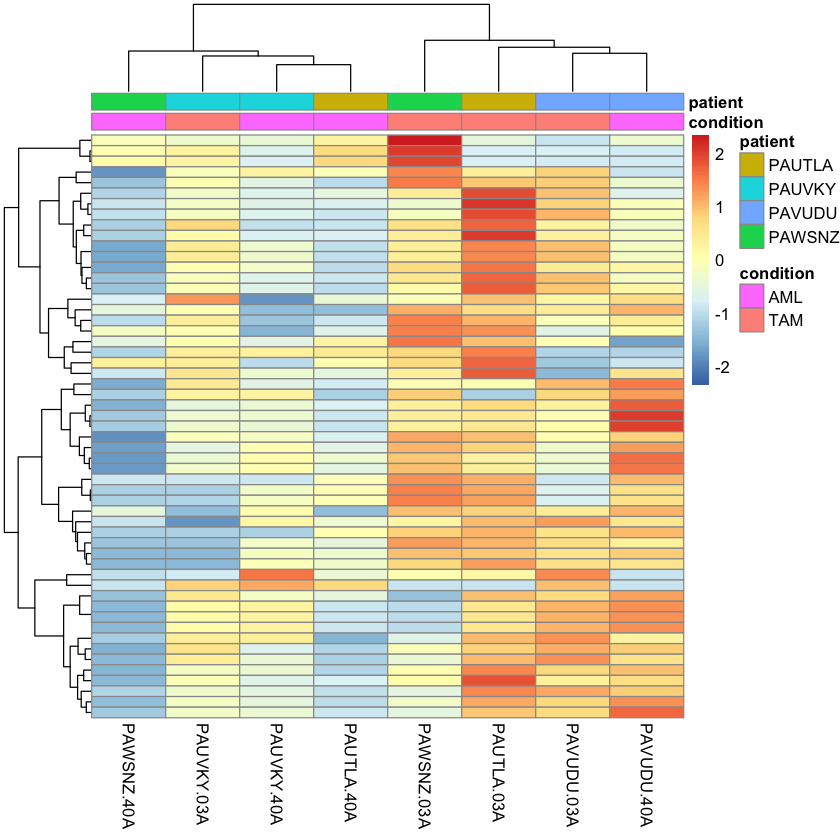

In [59]:
significant_out <- pheatmap(significant_expression, 
                            cluster_rows5=TRUE, 
                            show_rownames=FALSE,
                            cluster_cols=TRUE, 
                            annotation_col=df, 
                            scale="row",
                            clustering_method = "ward.D2",
                            clustering_distance_cols = "minkowski", 
                            clustering_distance_rows = "minkowski" )

[1] 55

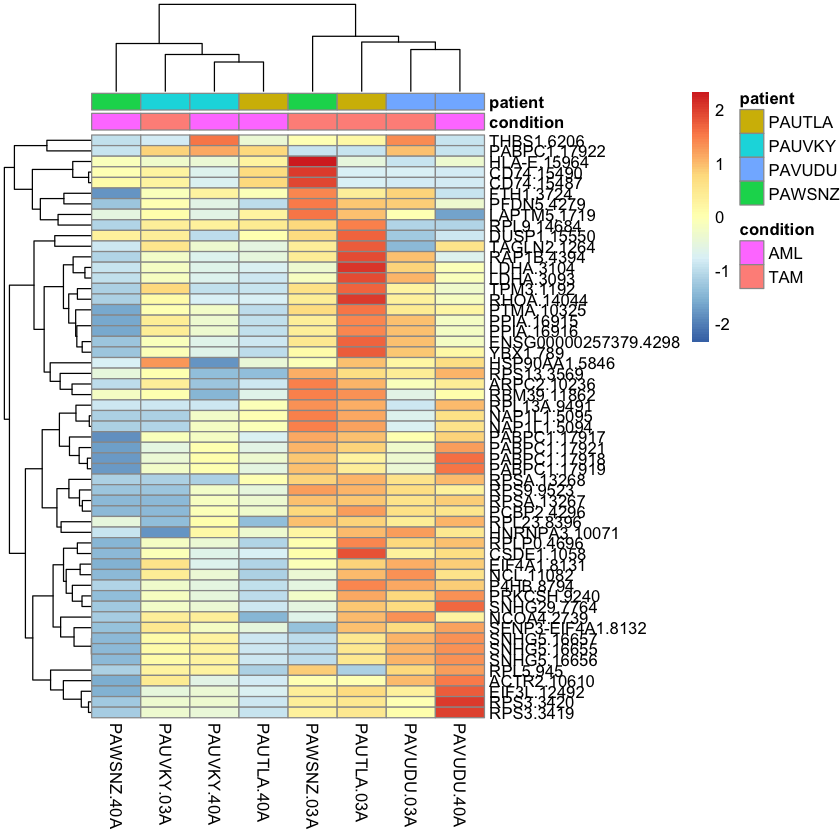

In [60]:
top_significant_genes <- dge[rownames(significant_genes),]
top_gene_list <- as.matrix(featureData[rownames(significant_expression),2])
length(top_gene_list)

start=1
stop=length(top_gene_list)
date  <- "2024Feb26_voom_10fold_"
piece <-top_significant_genes[significant_out$tree_row$order[start:stop],]
fd    <- data.frame(featureData[rownames(piece),])
genejunction <- paste(featureData[rownames(piece),2],rownames(piece),sep=".")
rownames(fd) <- genejunction
rownames(piece) <- genejunction
outpiece<-pheatmap(piece, cluster_rows5=TRUE, show_rownames=TRUE,
         cluster_cols=TRUE, annotation_col=df, scale="row",clustering_distance_cols = "minkowski", clustering_distance_rows = "minkowski" )
piece_filename <- paste(paste(paste(paste(date,"MXE_voom_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
piece_exp <- piece[,c(1,3,5,7,2,4,6,8)]
colnames(piece_exp) <- colnames(piece[,c(1,3,5,7,2,4,6,8)])
rownames(piece_exp) <- rownames(piece)
string_filename <- paste(paste(paste(paste(date,"MXE_voom_string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
piece_exp_filename <- paste(paste(paste(paste(date,"MXE_voom_expression_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
write.csv(piece_exp$counts,piece_exp_filename,quote=FALSE)
write.csv(rownames(piece),piece_filename,quote=FALSE,row.names=FALSE)
write.csv(fd[,2],string_filename,quote=FALSE,row.names=FALSE)

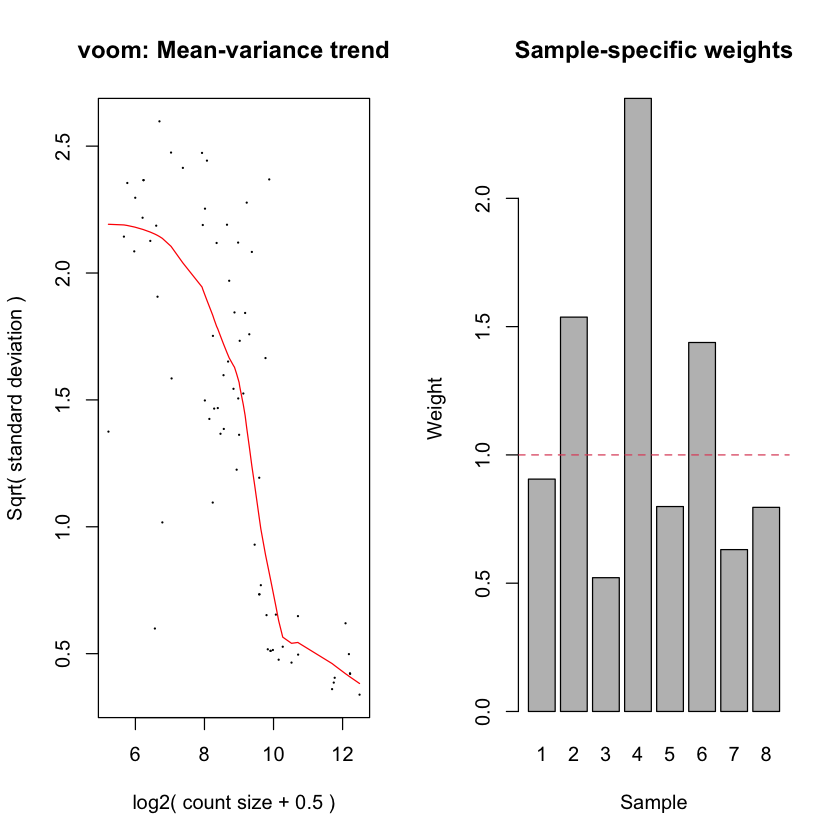

In [61]:
vwts <- voomWithQualityWeights(dge, design=design, normalize.method="quantile", plot=TRUE)

In [62]:
vwtsfit <- lmFit(vwts, design, weights = vwts$weights )
vwtsfit <- eBayes(vwtsfit, trend=TRUE)
de_results <- topTable(vwtsfit, coef=ncol(design), n=Inf) 
lookup <- rownames(de_results)
length(featureData[lookup,2])
head(featureData[lookup,2])


[1] 72

17921    17918    17919     3420    17917    10325 
"PABPC1" "PABPC1" "PABPC1"   "RPS3" "PABPC1"   "PTMA"

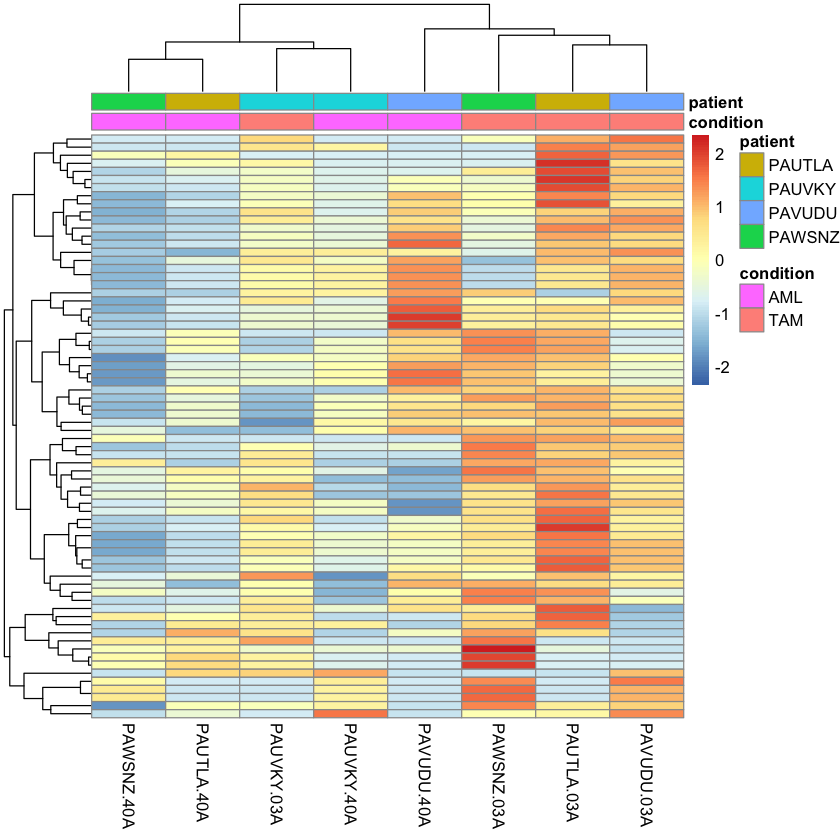

In [63]:
library("pheatmap")
df <- as.data.frame(coldata[,c("condition","patient")])
dge_expression <- dge[lookup,]
out <- pheatmap(dge_expression, cluster_rows5=TRUE, show_rownames=FALSE,
         cluster_cols=TRUE, annotation_col=df, scale="row",clustering_distance_cols = "minkowski", clustering_distance_rows = "minkowski" )

In [64]:
# Assuming you have the 'de_results' object from topTable
fold_change_threshold <- 10
adjusted_pvalue_threshold <- 0.05

# Select genes that meet both fold change and adjusted p-value criteria
significant_genes <- de_results[
  abs(de_results$logFC) > fold_change_threshold &
  de_results$adj.P.Val < adjusted_pvalue_threshold,
]


In [65]:
lookup <- rownames(significant_genes)
significant_expression <- dge[lookup,]

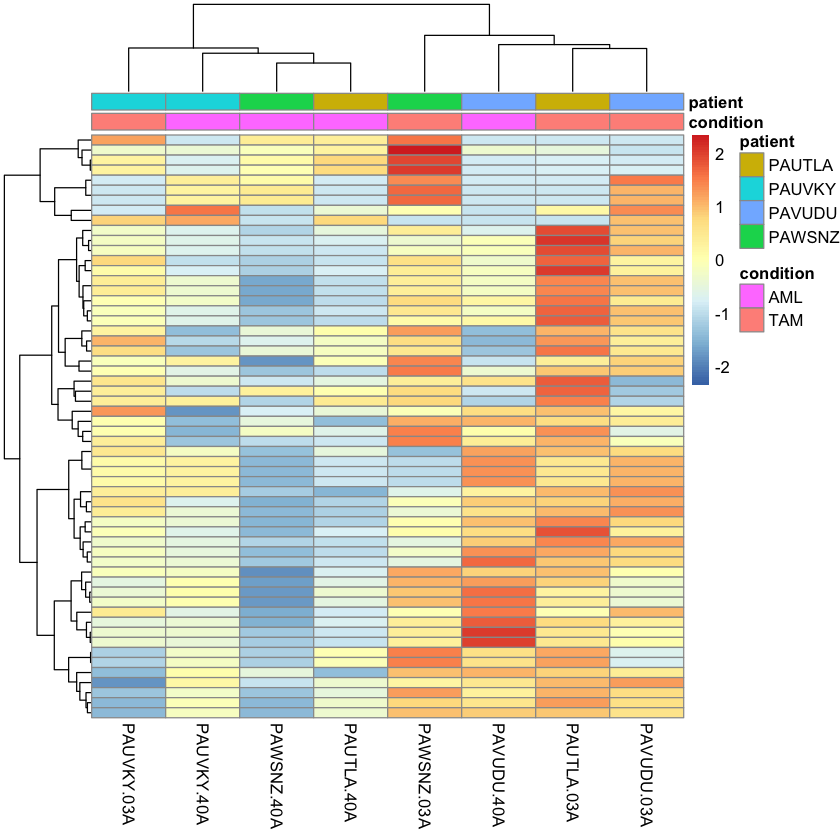

In [66]:
significant_out <- pheatmap(significant_expression, 
                            cluster_rows5=TRUE, 
                            show_rownames=FALSE,
                            cluster_cols=TRUE, 
                            annotation_col=df, 
                            scale="row",
                            clustering_method = "ward.D2",
                            clustering_distance_cols = "minkowski", 
                            clustering_distance_rows = "minkowski" )

[1] 58

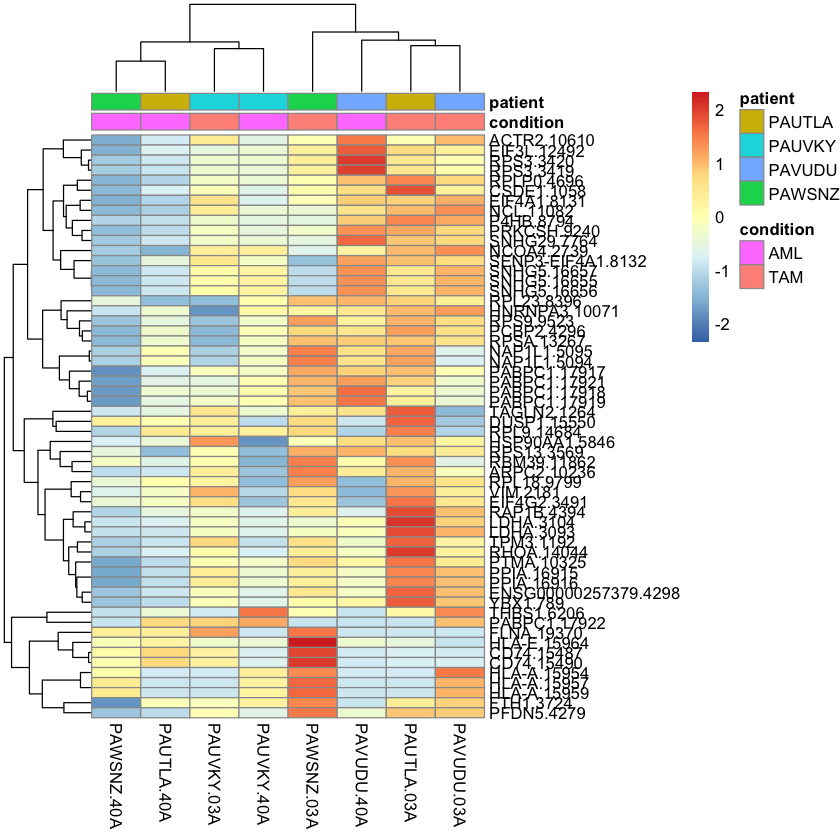

In [67]:
top_significant_genes <- dge[rownames(significant_genes),]
top_gene_list <- as.matrix(featureData[rownames(significant_expression),2])
length(top_gene_list)

start=1
stop=length(top_gene_list)
date  <- "2024Feb26_vwts_10fold"
piece <-top_significant_genes[significant_out$tree_row$order[start:stop],]
fd    <- data.frame(featureData[rownames(piece),])
genejunction <- paste(featureData[rownames(piece),2],rownames(piece),sep=".")
rownames(fd) <- genejunction
rownames(piece) <- genejunction
outpiece<-pheatmap(piece, cluster_rows5=TRUE, show_rownames=TRUE,
         cluster_cols=TRUE, annotation_col=df, scale="row",clustering_distance_cols = "minkowski", clustering_distance_rows = "minkowski" )
piece_filename <- paste(paste(paste(paste(date,"MXE_vwts_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
piece_exp <- piece[,c(1,3,5,7,2,4,6,8)]
colnames(piece_exp) <- colnames(piece[,c(1,3,5,7,2,4,6,8)])
rownames(piece_exp) <- rownames(piece)
string_filename <- paste(paste(paste(paste(date,"MXE_vwts_string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
piece_exp_filename <- paste(paste(paste(paste(date,"MXE_vwts_expression_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
write.csv(piece_exp$counts,piece_exp_filename,quote=FALSE)
write.csv(rownames(piece),piece_filename,quote=FALSE,row.names=FALSE)
write.csv(fd[,2],string_filename,quote=FALSE,row.names=FALSE)

In [68]:
save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}
save_pheatmap_pdf(out, "2024Feb26_vwts_10fold_top_significant_genes.pdf")

pdf 
  2

In [69]:
#Re-order original data (genes) to match ordering in heatmap (top-to-bottom)
rn <- rownames(top_significant_genes[significant_out$tree_row[["order"]],])
cn <- colnames(top_significant_genes[,significant_out$tree_col[["order"]]])

In [70]:
#If you want something like gene-to-cluster assignment, you can 'cut' your row dendrogram into a pre-selected number of groups as follows:
# 3 groups
clusters<- as.matrix(row_clusters<- sort(cutree(significant_out$tree_row, k=6)),nrows=dim(top_genes_expression)[1],ncols=1)
genes_in_clusters = featureData[rownames(clusters),2]
genes_in_clusters.df <- data.frame(featureData[rownames(clusters),2], clusters)
colnames(genes_in_clusters.df) <- c("geneSymbol","cluster")
dim(genes_in_clusters.df)
cluster_1_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 1,]
cluster_2_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 2,]
cluster_3_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 3,]

cluster_1_filename <- paste(paste(date, "_cluster_1", sep="_"),"csv",sep=".")
cluster_2_filename <- paste(paste(date, "_cluster_2", sep="_"),"csv",sep=".")
cluster_3_filename <- paste(paste(date, "_cluster_3", sep="_"),"csv",sep=".")

write.csv(cluster_1_genes$geneSymbol,cluster_1_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_2_genes$geneSymbol,cluster_2_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_3_genes$geneSymbol,cluster_3_filename,quote=FALSE,row.names=FALSE)


[1] 58  2